In [2]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


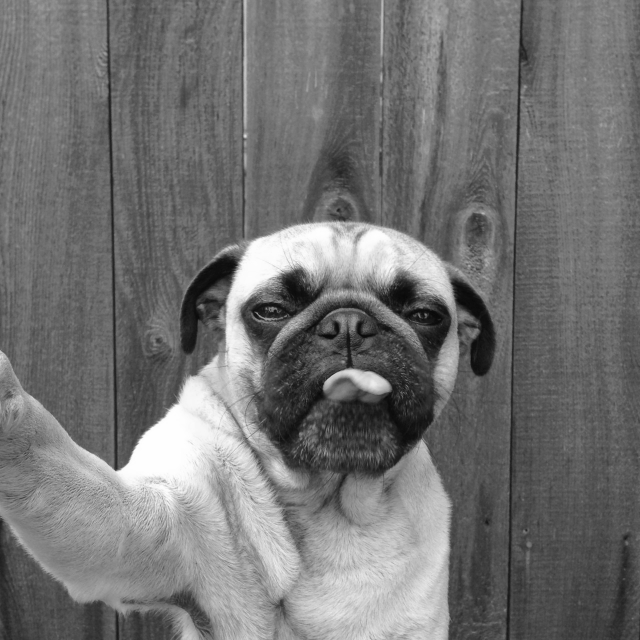

In [3]:
path = "/content/drive/MyDrive/Colab Notebooks/national-selfie-day-dogs1.jpg"
# img = cv2.imread(path,flags=cv2.IMREAD_COLOR)
scale = 0.5
img = cv2.imread(path)
img = cv2.cvtColor(np.float32(img), cv2.COLOR_RGB2GRAY)
img = cv2.resize(img,dsize=((int)(img.shape[1]*scale),(int)(img.shape[0]*scale)))
cv2_imshow(img)

## Canny edge detection

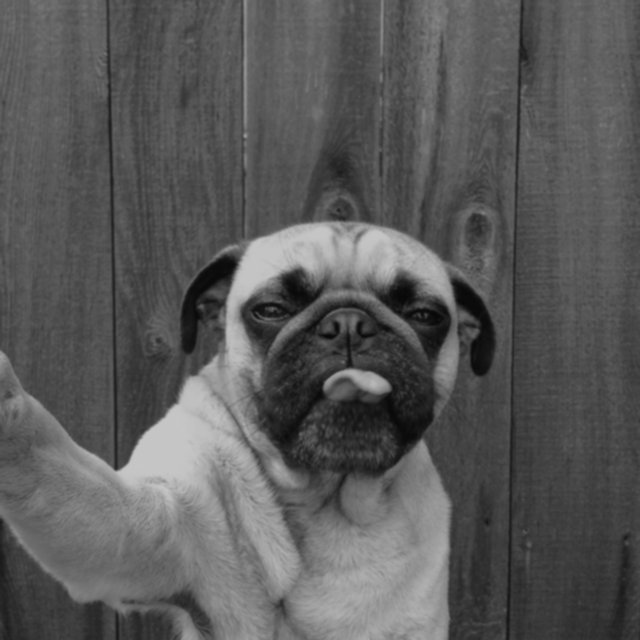

In [ ]:
# noise reduction with gaussian blur
def gaussian_kernel(ksize:int, sigma:int=1):
    size = ksize//2
    x,y = np.mgrid[-size:size+1,-size:size+1]
    norm = 1 / (2.0 * np.pi * sigma**2)
    g = norm * np.exp(-(x**2 + y**2)/(2.0 * sigma**2))
    return g

ksize = 3
g = gaussian_kernel(ksize)
bimg = cv2.filter2D(img, ddepth=-1, kernel=g)
cv2_imshow(bimg)

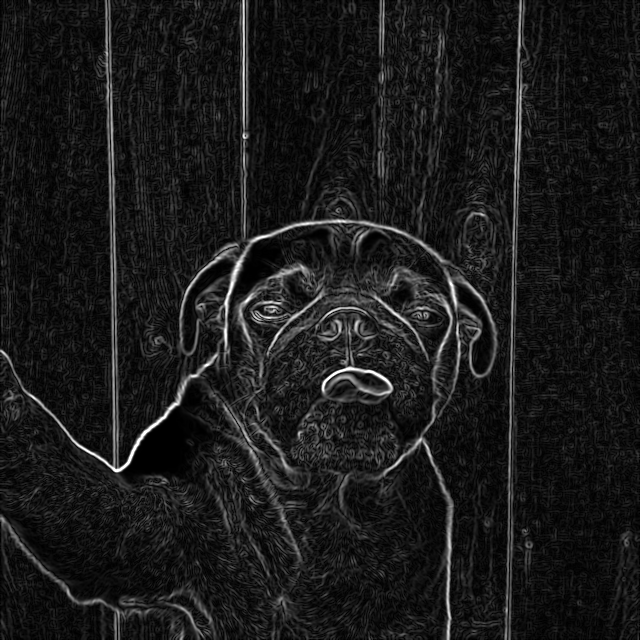

In [ ]:
# gradient calculation
def sobel_filter(img):
    kx = np.array([[-1, 0 , 1],
                [-2, 0, 2],
                [-1, 0, 1]], dtype=np.float32)
    ky = np.array([[1, 2, 1],
                [0, 0, 0],
                [-1, -2, -1]], dtype=np.float32)

    ximg = cv2.filter2D(img, ddepth=-1, kernel=kx)
    yimg = cv2.filter2D(img, ddepth=-1, kernel=ky)

    gimg = np.sqrt(ximg**2 + yimg**2)
    theta = np.arctan2(yimg, ximg)
    
    return gimg, timg

gimg, timg = sobel_filter(bimg)
cv2_imshow(gimg)

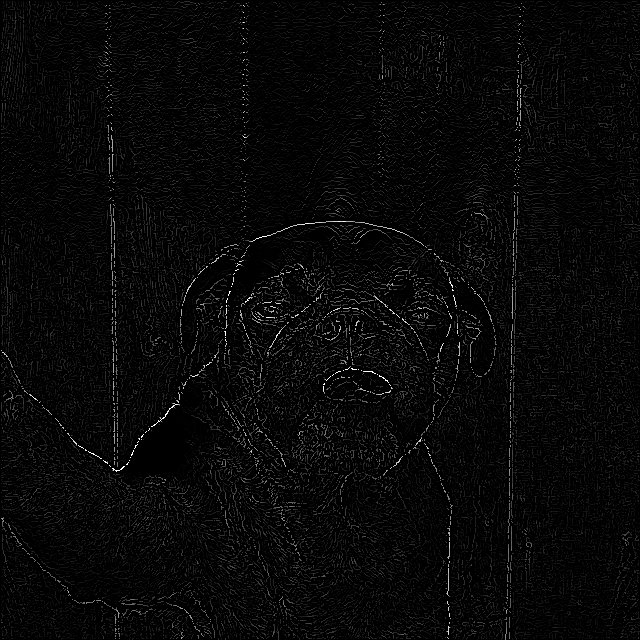

In [ ]:
# nonmaximum suppression
def nonmax_suppression(img, direc):
    h,w = img.shape
    angle = direc * 180.0 / np.pi
    angle[angle < 0] += 180

    re = np.zeros((h,w), dtype=np.int32)

    for i in range(1, h):
        for j in range(1, w):
            try:
                n1 = 255
                n2 = 255

                # angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] < 180):
                    n1 = img[i, j + 1]
                    n2 = img[i, j - 1]
                # angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    n1 = img[i + 1, j - 1]
                    n2 = img[i - 1, j + 1]
                # angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    n1 = img[i + 1, j]
                    n2 = img[i - 1, j]
                # angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    n1 = img[i - 1, j - 1]
                    n2 = img[i + 1, j + 1]
                
                if (img[i,j] >= n1) and (img[i,j] >= n2):
                    re[i,j] = img[i,j]
                else:
                    re[i,j] = 0

            except IndexError:
                    pass
    return re

nsimg = nonmax_suppression(gimg, timg)
cv2_imshow(nsimg)

75 255


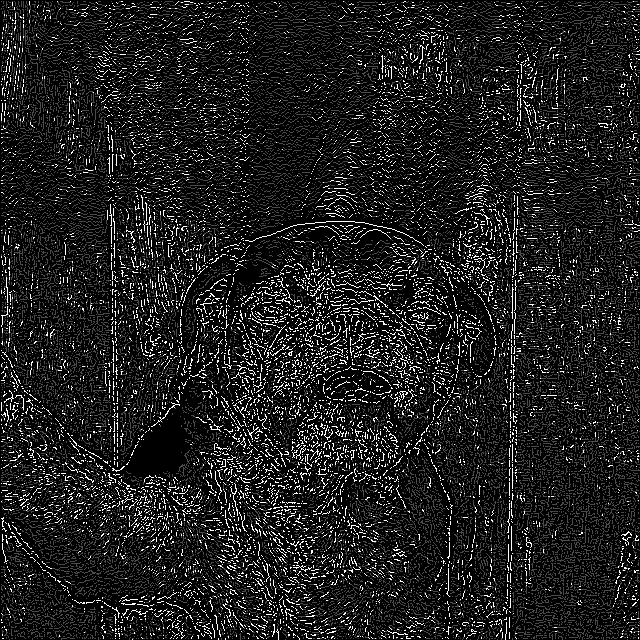

In [ ]:
# double thresholding
def thresholding(img, low_ratio=0.05, high_ratio=0.09):
    hi = img.max() * high_ratio
    lo = hi * low_ratio

    h,w = img.shape
    re = np.zeros((h,w), dtype=np.int32)

    weak = np.int32(75)
    strong = np.int32(255)

    st_i, st_j = np.where(img >= hi)
    wk_i, wk_j = np.where((img >= lo) & (img < hi))
    zr_i, zr_j = np.where(img < lo)

    re[st_i, st_j] = strong
    re[wk_i, wk_j] = weak

    return re, weak, strong

thrimg, weak, strong = thresholding(nsimg)
print(weak, strong)
cv2_imshow(thrimg)

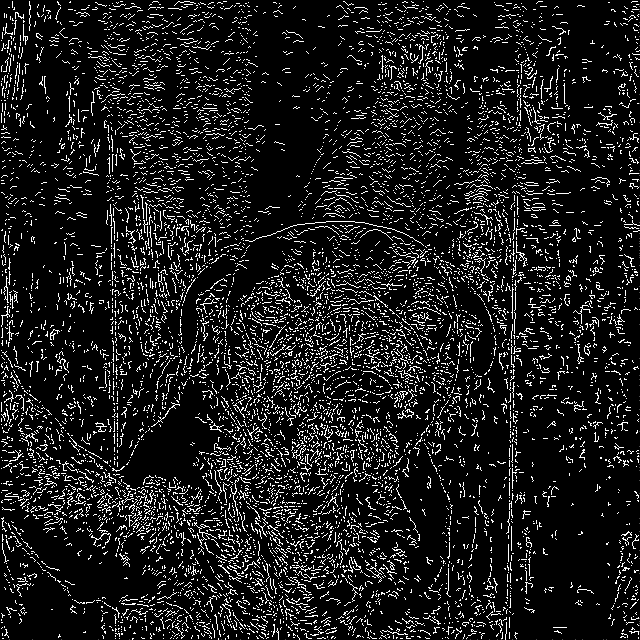

In [ ]:
# edge tracking by hysteresis
def hysteresis(img, weak, strong=255):
    h,w = img.shape
    for i in range(1,h - 1):
        for j in range(1, w - 1):
            if (img[i,j] == weak):
                try:
                    if ((img[i - 1, j - 1] == strong) or (img[i - 1, j] == strong) or (img[i - 1, j + 1] == strong) or (img[i, j - 1] == strong) or (img[i, j + 1] == strong) or (img[i + 1, j - 1] == strong) or (img[i + 1, j] == strong) or (img[i + 1, j + 1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError:
                    pass
    return img

hyimg = hysteresis(thrimg, weak)

cv2_imshow(hyimg)

## Canny edge detector

In [5]:
import cv2
import numpy as np

class Canny:
    def __init__(self, imgs, sigma=1, ksize=5, weak_pixel=75, strong_pixel=255, low_ratio=0.05, high_ratio=0.2):
        self.imgs = imgs
        self.imgs_final = []
        self.img_smoothed = None
        self.gradientMat = None
        self.thetaMat = None
        self.nonMaxImg = None
        self.thresholdImg = None
        self.weak_pixel = weak_pixel
        self.strong_pixel = strong_pixel
        self.sigma = sigma
        self.ksize = ksize
        self.low_ratio = low_ratio
        self.high_ratio = high_ratio
        return 
    
    def gaussian_kernel(self, ksize=5, sigma=1):
        size = ksize//2
        x,y = np.mgrid[-size:size+1,-size:size+1]
        norm = 1 / (2.0 * np.pi * sigma**2)
        g = norm * np.exp(-(x**2 + y**2)/(2.0 * sigma**2))
        return g

    def sobel_filter(self, img):
        kx = np.array([[-1, 0 , 1],
                    [-2, 0, 2],
                    [-1, 0, 1]], dtype=np.float32)
        ky = np.array([[1, 2, 1],
                    [0, 0, 0],
                    [-1, -2, -1]], dtype=np.float32)

        ximg = cv2.filter2D(img, ddepth=-1, kernel=kx)
        yimg = cv2.filter2D(img, ddepth=-1, kernel=ky)

        gimg = np.sqrt(ximg**2 + yimg**2)
        theta = np.arctan2(yimg, ximg)
        
        return (gimg, theta)
    
    def nonmax_suppression(self, img, direc):
        h,w = img.shape
        angle = direc * 180.0 / np.pi
        angle[angle < 0] += 180

        re = np.zeros((h,w), dtype=np.int32)

        for i in range(1, h):
            for j in range(1, w):
                try:
                    n1 = 255
                    n2 = 255

                    # angle 0
                    if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] < 180):
                        n1 = img[i, j + 1]
                        n2 = img[i, j - 1]
                    # angle 45
                    elif (22.5 <= angle[i,j] < 67.5):
                        n1 = img[i + 1, j - 1]
                        n2 = img[i - 1, j + 1]
                    # angle 90
                    elif (67.5 <= angle[i,j] < 112.5):
                        n1 = img[i + 1, j]
                        n2 = img[i - 1, j]
                    # angle 135
                    elif (112.5 <= angle[i,j] < 157.5):
                        n1 = img[i - 1, j - 1]
                        n2 = img[i + 1, j + 1]
                    
                    if (img[i,j] >= n1) and (img[i,j] >= n2):
                        re[i,j] = img[i,j]
                    else:
                        re[i,j] = 0

                except IndexError:
                        pass
        return re

    def threshold(self, img):
        hi = img.max() * self.high_ratio
        lo = hi * self.low_ratio

        h,w = img.shape
        re = np.zeros((h,w), dtype=np.int32)

        weak = np.int32(self.weak_pixel)
        strong = np.int32(self.strong_pixel)

        st_i, st_j = np.where(img >= hi)
        wk_i, wk_j = np.where((img >= lo) & (img < hi))
        zr_i, zr_j = np.where(img < lo)

        re[st_i, st_j] = strong
        re[wk_i, wk_j] = weak

        return re

    def hysteresis(self, img):
        h,w = img.shape

        weak = self.weak_pixel
        strong = self.strong_pixel

        for i in range(1,h - 1):
            for j in range(1, w - 1):
                if (img[i,j] == weak):
                    try:
                        if ((img[i - 1, j - 1] == strong) or (img[i - 1, j] == strong) or (img[i - 1, j + 1] == strong) or (img[i, j - 1] == strong) or (img[i, j + 1] == strong) or (img[i + 1, j - 1] == strong) or (img[i + 1, j] == strong) or (img[i + 1, j + 1] == strong)):
                            img[i, j] = strong
                        else:
                            img[i, j] = 0
                    except IndexError:
                        pass
        return img

    def detect(self):
        imgs_final = []
        for i, img in enumerate(self.imgs):    
            # self.img_smoothed = convolve(img, self.gaussian_kernel(self.kernel_size, self.sigma))
            self.img_smoothed = cv2.filter2D(img, ddepth=-1, kernel=self.gaussian_kernel(self.ksize, self.sigma))
            self.gradientMat, self.thetaMat = self.sobel_filter(self.img_smoothed)
            self.nonMaxImg = self.nonmax_suppression(self.gradientMat, self.thetaMat)
            self.thresholdImg = self.threshold(self.nonMaxImg)
            img_final = self.hysteresis(self.thresholdImg)
            self.imgs_final.append(img_final)

        return self.imgs_final

In [6]:
c = Canny(imgs=[img])
re = c.detect()

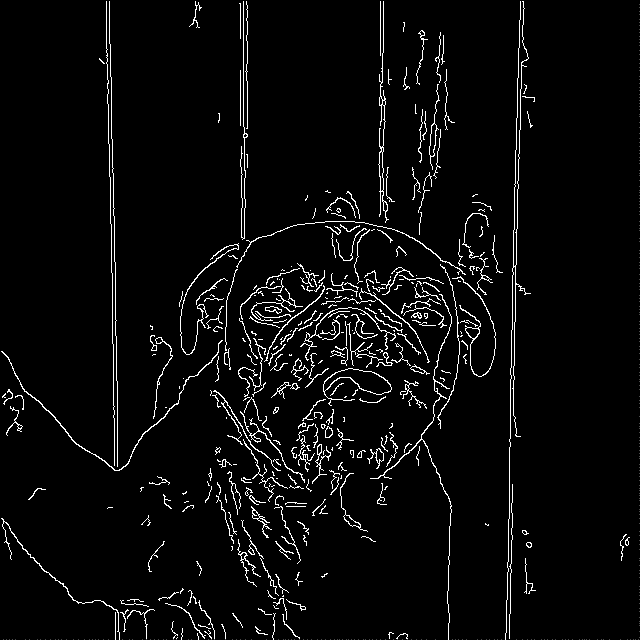

In [9]:
cv2_imshow(re[0])
# len(re)